In [161]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score
import os
import glob
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import warnings, cv2
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from keras.models import Sequential, load_model
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/surface-crack/valid/Negative/IMG_2626_8_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0293_4_10.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2979_8_7.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2511_4_13.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_9627_8_9.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0254_7_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2977_3_3.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0254_9_6.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2016_1_11.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2010_2_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_1424_5_16.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2979_8_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0472_10_10.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0471_3_5.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2015_11_3.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2626_8_7.jpg
/kaggle/input/surface-crack/valid

# Data Visualization

In [162]:
positive_dir = Path(r'/kaggle/input/surface-crack/test/Positive')
negative_dir = Path(r'/kaggle/input/surface-crack/test/Negative')
 

def generate_df(img_dir, label):
    
    file_Path = pd.Series(list(img_dir.glob(r'*.jpg')), name='File_Path').astype(str)
    labels = pd.Series(label, name='Label', index=file_Path.index)
    df = pd.concat([file_Path, labels], axis=1)
    
    return df


In [163]:
positive_df = generate_df(positive_dir, 'POSITIVE')
negative_df = generate_df(negative_dir, 'NEGATIVE')

# concatenate both positive and negative df
all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1, random_state=1).reset_index(drop=True)


In [164]:
all_df.head()


,File_Path,Label
0,/kaggle/input/surface-crack/test/Positive/DJI_...,POSITIVE
1,/kaggle/input/surface-crack/test/Positive/DJI_...,POSITIVE
2,/kaggle/input/surface-crack/test/Positive/DJI_...,POSITIVE
3,/kaggle/input/surface-crack/test/Negative/DJI_...,NEGATIVE
4,/kaggle/input/surface-crack/test/Negative/DJI_...,NEGATIVE


In [165]:
path = 'data/'
path_all = list(glob.glob(path+'**/*jpg'))
positive_df = path + 'Negative/*.jpg'
negative_df = path + 'Positive/*.jpg'


Text(0.5, 1.0, 'Negative & Positive')

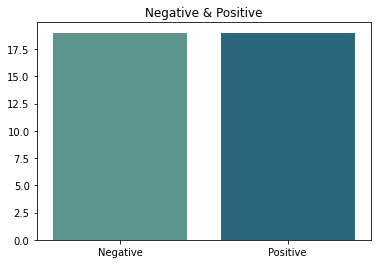

In [166]:
sns.barplot(x=['Negative','Positive'], y=[len(negative_df), len(positive_df)], palette='crest' )
plt.title('Negative & Positive')

In [167]:
positive_dir = Path(r'/kaggle/input/surface-crack/train/Positive')
negative_dir = Path(r'/kaggle/input/surface-crack/train/Negative')


In [168]:

def generate_df(img_dir, label):
    
    file_Path = pd.Series(list(img_dir.glob(r'*.jpg')), name='File_Path').astype(str)
    labels = pd.Series(label, name='Label', index=file_Path.index)
    df = pd.concat([file_Path, labels], axis=1)
    
    return df

In [169]:
positive_df = generate_df(positive_dir, 'POSITIVE')
negative_df = generate_df(negative_dir, 'NEGATIVE')

# concatenate both positive and negative df
all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1, random_state=1).reset_index(drop=True)
all_df.head()


,File_Path,Label
0,/kaggle/input/surface-crack/train/Negative/IMG...,NEGATIVE
1,/kaggle/input/surface-crack/train/Negative/IMG...,NEGATIVE
2,/kaggle/input/surface-crack/train/Negative/IMG...,NEGATIVE
3,/kaggle/input/surface-crack/train/Negative/IMG...,NEGATIVE
4,/kaggle/input/surface-crack/train/Positive/IMG...,POSITIVE


In [170]:
path = 'data/'
path_all = list(glob.glob(path+'**/*jpg'))
positive_df = path + 'Negative/*.jpg'
negative_df = path + 'Positive/*.jpg'


<AxesSubplot:>

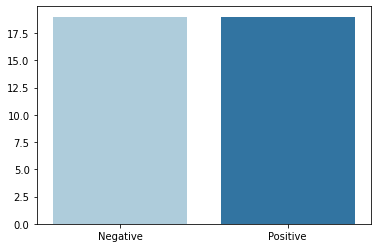

In [171]:
sns.barplot(x=['Negative','Positive'], y=[len(negative_df), len(positive_df)], palette='Paired' )


Text(0.5, 1.0, 'Negative & Positive')

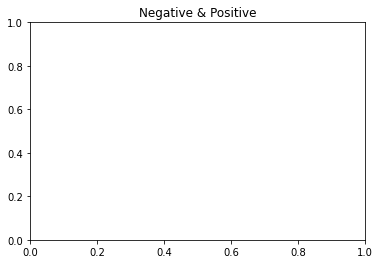

In [172]:
plt.title('Negative & Positive')


In [173]:
train_dir, test_dir = train_test_split(all_df,train_size=0.7,shuffle=True,random_state=42)


In [174]:
train_dir.shape


(420, 2)

In [175]:
test_dir.shape

(180, 2)

Text(0.5, 1.0, 'Train & Test')

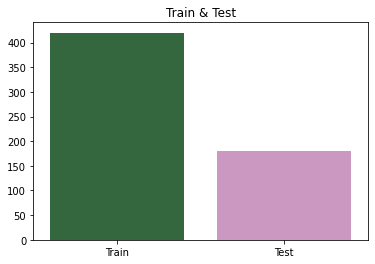

In [176]:
sns.barplot(x=['Train','Test'], y=[len(train_dir), len(test_dir)], palette='cubehelix' )
plt.title('Train & Test')


# Data Preprocessing

In [177]:
train_dir = "../input/surface-crack/train/"
test_dir = "../input/surface-crack/test/"

In [178]:
def load_images(directory):
    images = []
    labels = []
    
    for category in os.listdir(directory):
        for filename in tqdm(os.listdir(directory+category)):
            image_path = os.path.join(directory,category,filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(224,224))
            images.append(image)
            labels.append(category)
    
    images = np.array(images,dtype='float32')
    return images, labels

In [179]:
X_train, y_train = load_images(train_dir)
X_test, y_test = load_images(test_dir)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [180]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [181]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
ytr=y_train
yte=y_test
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# CNN Model

In [182]:
model = Sequential()
model.add(Conv2D(64,3,padding="same", activation="relu",input_shape=(224,224,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256,activation="relu",kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(2, activation="sigmoid"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 100352)           

In [183]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

In [184]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=20,mode='max',verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=5,mode='max',verbose=1,factor=0.1,min_lr=0.001)
checkpoint_filename = 'checkpoint/'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filename,monitor='val_accuracy',verbose=1,save_best_only=True,save_weights_only=True,mode='max')

r = model.fit(x=X_train,
            y=y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_test,y_test),
            callbacks=[early_stopping,reduce_lr,model_checkpoint])

Epoch 1/50
19/19 [==============================] - 2s 63ms/step - loss: 1.1182 - accuracy: 0.5917 - val_loss: 3.7800 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to checkpoint/
Epoch 2/50
19/19 [==============================] - 1s 48ms/step - loss: 1.1194 - accuracy: 0.6500 - val_loss: 4.9747 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/50
19/19 [==============================] - 1s 48ms/step - loss: 1.1462 - accuracy: 0.5483 - val_loss: 7.2614 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.50000
Epoch 4/50
19/19 [==============================] - 1s 47ms/step - loss: 1.0852 - accuracy: 0.5783 - val_loss: 4.2470 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.50000
Epoch 5/50
19/19 [==============================] - 1s 48ms/step - loss: 0.9185 - accuracy: 0.7833 - val_loss: 1.8791 - val_accuracy: 0.5000

Epoch 00005: val_accuracy did not improv

In [185]:
model.load_weights(checkpoint_filename)

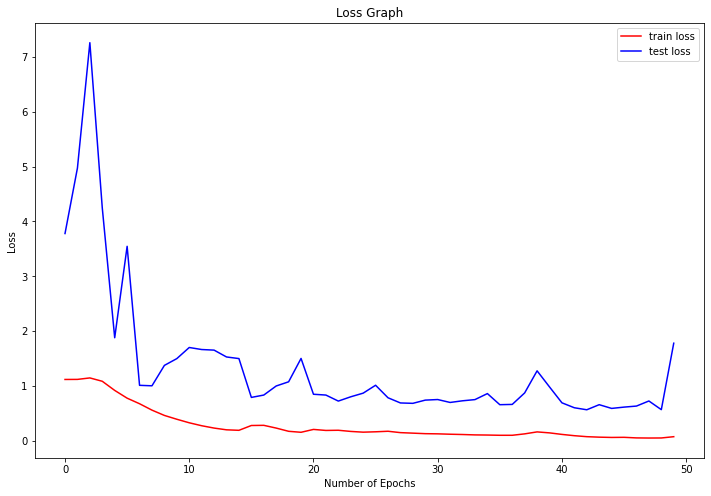

In [186]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

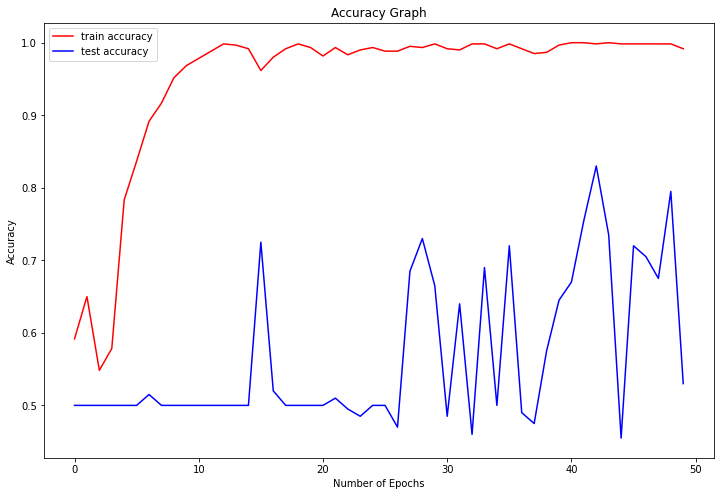

In [187]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [188]:
y_pred_train=model.predict(x=X_train)
y_pred_test=model.predict(x=X_test)

In [189]:
y_pred_test=np.argmax(y_pred_test, axis=1)
y_pred_train=np.argmax(y_pred_train, axis=1)

In [190]:
import sklearn.metrics
conftest=sklearn.metrics.confusion_matrix(yte, y_pred_test)
conftrain=sklearn.metrics.confusion_matrix(ytr, y_pred_train)
print(conftest)

[[98  2]
 [32 68]]


In [191]:
print(conftrain)

[[257  43]
 [  0 300]]


In [192]:
print(sklearn.metrics.accuracy_score(yte,y_pred_test))
print(sklearn.metrics.precision_score(yte,y_pred_test))
print(sklearn.metrics.recall_score(yte,y_pred_test))
print(sklearn.metrics.f1_score(yte,y_pred_test))

0.83
0.9714285714285714
0.68
0.8
